In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import string
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import time
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

In [4]:

# Set up warnings and visualization settings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style="whitegrid")

# suppress scientific notation
np.set_printoptions(suppress=True) 
pd.options.display.float_format = '{:.6f}'.format

# Read Data
email_df = pd.read_csv('D:/NTU/Final year project/spam_ham_dataset.csv')
email_df.head(10)

# Take a look at two example of not-spam and spam message
print('Example of not-spam message: ', email_df.loc[0, 'text'])
print('\nExample of spam message: ', email_df.loc[3, 'text'])

Example of not-spam message:  Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Example of spam message:  Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin



In [5]:
# Display the shape of the dataset (number of rows and columns)
print("Dataset Shape:", email_df.shape)

# Display the first few rows of the dataset
print("\nFirst Few Rows of the Dataset:")
print(email_df.head())

# Display basic statistical information about the dataset
print("\nStatistical Summary of the Dataset:")
print(email_df.describe())

# Display information about the dataset including data types and non-null counts
print("\nInformation about the Dataset:")
print(email_df.info())

Dataset Shape: (5171, 4)

First Few Rows of the Dataset:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  

Statistical Summary of the Dataset:
       Unnamed: 0   label_num
count 5171.000000 5171.000000
mean  2585.000000    0.289886
std   1492.883452    0.453753
min      0.000000    0.000000
25%   1292.500000    0.000000
50%   2585.000000    0.000000
75%   3877.500000    1.000000
max   5170.000000    1.000000

Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 

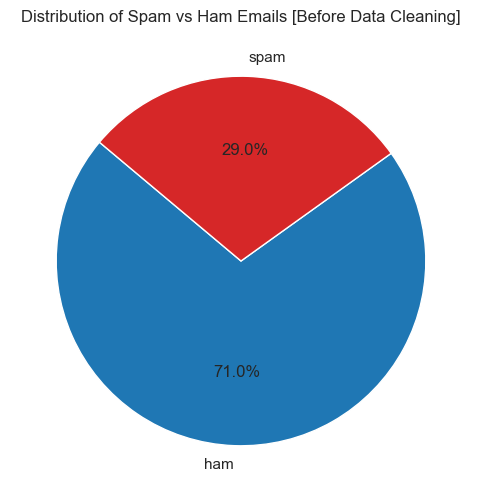

In [6]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom colors for "Ham" and "Spam"
colors = ["#1f77b4", "#d62728"]

# Count the occurrences of each category
category_counts = email_df['label'].value_counts()

# Create a pie chart with custom colors
plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, colors=colors, autopct='%.1f%%', startangle=140)

# Set the title
plt.title("Distribution of Spam vs Ham Emails [Before Data Cleaning]")

plt.show()


Missing Values  Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


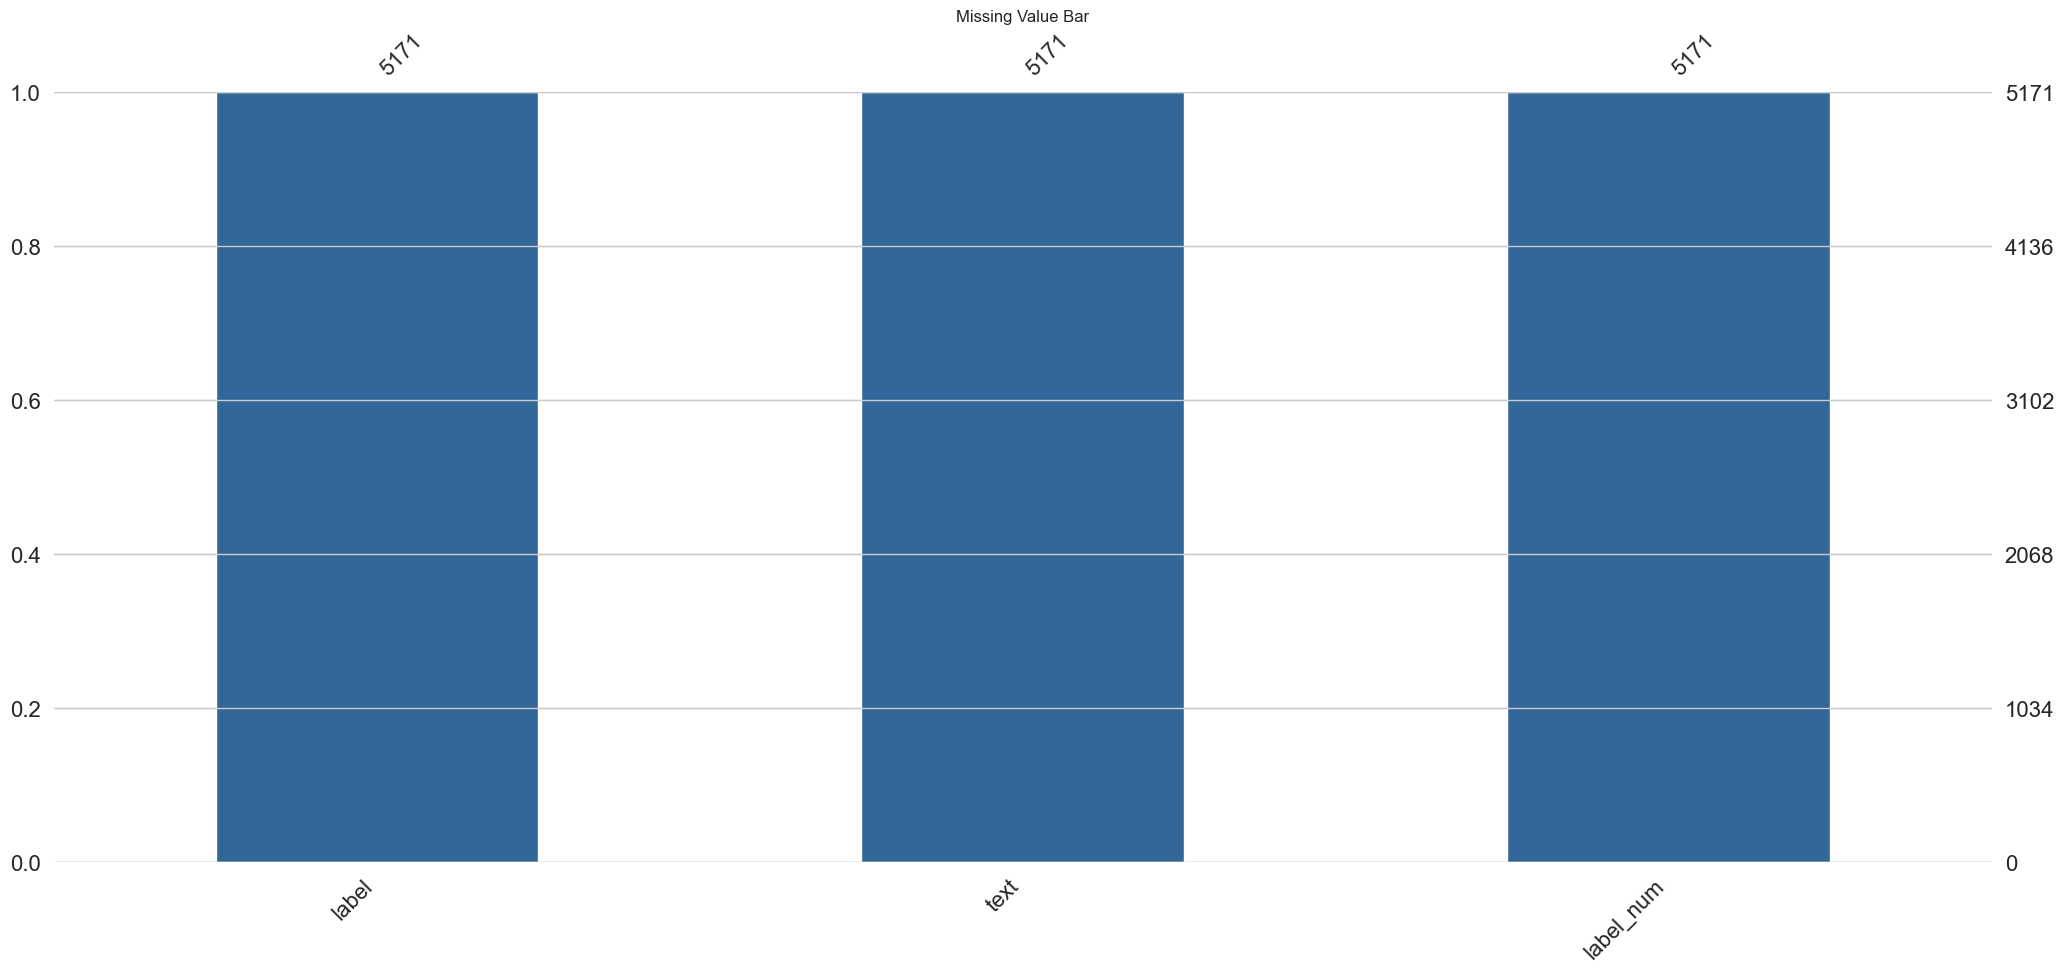

(5171, 3)
Duplicate Rows:
     label                                               text  label_num
182   spam                                      subject: \r\n          1
296   spam                                      subject: \r\n          1
363   spam                                      subject: \r\n          1
436    ham  subject: cornhusker up on 24 th\r\nspoke with ...          0
624    ham  subject: enron / hpl actuals for november 13 ,...          0
...    ...                                                ...        ...
5061   ham  subject: tenaska iv\r\nbob :\r\ni understand f...          0
5064  spam  subject: \r\nthis week only : f . ree gen . er...          1
5089  spam  subject: \r\nthe permanent fix to penis growth...          1
5155   ham  subject: cleburne - tenaska iv plant\r\ndaren ...          0
5168   ham  subject: calpine daily gas nomination\r\n>\r\n...          0

[178 rows x 3 columns]
Original Dataset Shape: (5171, 3)
Cleaned Dataset Shape: (4993, 3)


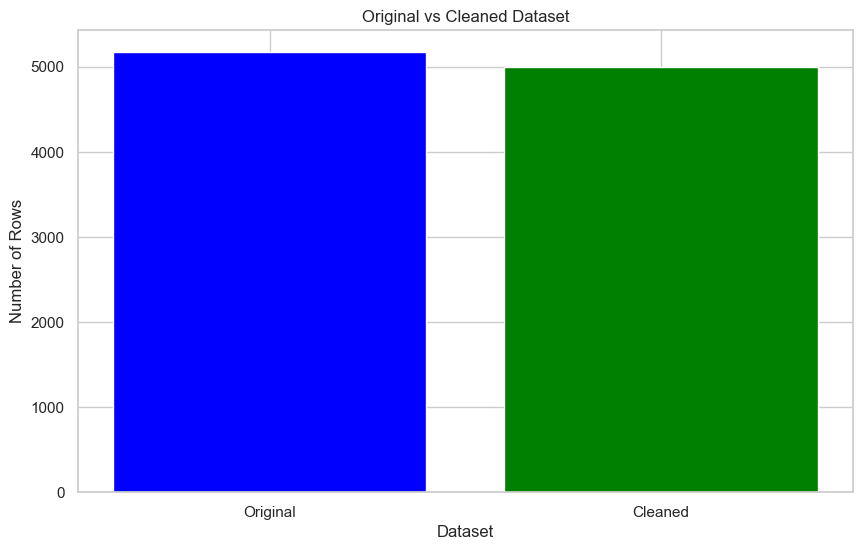

New updated dataset shape:  (4993, 3)


label_num                                                        \
            count     mean      std      min      25%      50%      75%   
label                                                                     
ham   3531.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
spam  1462.000000 1.000000 0.000000 1.000000 1.000000 1.000000 1.000000   

                
           max  
label           
ham   0.000000  
spam  1.000000

In [7]:

email_df['text'] = email_df['text'].str.lower()

# Check for missing values in the dataset
missing_values = email_df.isnull().sum()

# Print the count of missing values for each column
print("Missing Values ",missing_values)

email_df.drop(columns=["Unnamed: 0"], inplace=True)

# Visualize missing values using a matrix

# Set color and type
color = (0.2, 0.4, 0.6)  
plot_type = 'bar'        

# Visualize missing values using the specified color and type
if plot_type == 'bar':
    msno.bar(email_df, color=color)
elif plot_type == 'matrix':
    msno.matrix(email_df, color=color)
elif plot_type == 'heatmap':
    msno.heatmap(email_df, cmap='coolwarm', figsize=(10, 6))

plt.title(f'Missing Value {plot_type.capitalize()}')
plt.show()

print(email_df.shape)
email_df.head(10)

# Check for duplicate rows
duplicates = email_df.duplicated()

# Print the duplicate rows
print("Duplicate Rows:")
print(email_df[duplicates])

# Remove duplicate rows and keep the first occurrence
email_df_cleaned = email_df.drop_duplicates()


# Print the shape of the original and cleaned datasets
print("Original Dataset Shape:", email_df.shape)
print("Cleaned Dataset Shape:", email_df_cleaned.shape)

# Visualization of the difference
plt.figure(figsize=(10, 6))
plt.bar(['Original', 'Cleaned'], [email_df.shape[0], email_df_cleaned.shape[0]], color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Number of Rows')
plt.title('Original vs Cleaned Dataset')
plt.show()

email_df.drop_duplicates(inplace=True)

print("New updated dataset shape: ", email_df.shape)


# Group the data by the 'label' column and apply the 'describe' method to each group
description_by_label = email_df.groupby('label').describe()

# Display the description by 'label' column
description_by_label


# Insights

1) Duplicates are present in dataframe very small quantity = 178 rows

2) Original Rows in DataFrame is : 5171 (Rows) and 3 (Columns)

3) After Checking duplicates, Unique rows is : 4993 (Rows) and 3 (Columns)

4) There are '0' missing values in the dataset.

In [8]:
# Display the shape of the dataset (number of rows and columns)
print("Dataset Shape:", email_df.shape)

# Display the first few rows of the dataset
print("\nFirst Few Rows of the Dataset:")
print(email_df.head())

# Display basic statistical information about the dataset
print("\nStatistical Summary of the Dataset:")
print(email_df.describe())

# Display information about the dataset including data types and non-null counts
print("\nInformation about the Dataset:")
print(email_df.info())

Dataset Shape: (4993, 3)

First Few Rows of the Dataset:
  label                                               text  label_num
0   ham  subject: enron methanol ; meter # : 988291\r\n...          0
1   ham  subject: hpl nom for january 9 , 2001\r\n( see...          0
2   ham  subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  spam  subject: photoshop , windows , office . cheap ...          1
4   ham  subject: re : indian springs\r\nthis deal is t...          0

Statistical Summary of the Dataset:
        label_num
count 4993.000000
mean     0.292810
std      0.455098
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000

Information about the Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      4993 non-null   object
 1   text       4993 non-null   object
 2   label_num  4993 non-null 

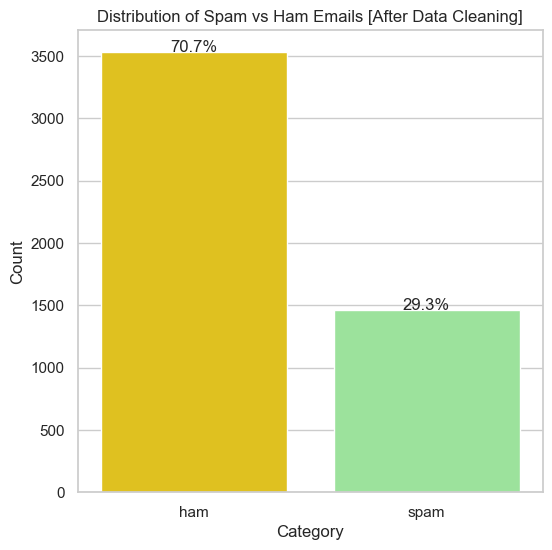

In [9]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Define custom colors for "Ham" and "Spam"
colors = ["#FFD700", "#90ee90"]

# Create a countplot with custom colors
plt.figure(figsize=(6, 6))
sns.countplot(data=email_df, x='label', palette=colors)

# Add percentages above the bars
total = len(email_df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2, height + 0.2, f'{height/total:.1%}', ha="center")

# Set the title and labels
plt.title("Distribution of Spam vs Ham Emails [After Data Cleaning]")
plt.xlabel("Category")
plt.ylabel("Count")

plt.show()

Average ham length = 994.94
Most frequent ham length = 95
Average spam length = 1249.33
Most frequent spam length = 74


<Figure size 1000x600 with 0 Axes>

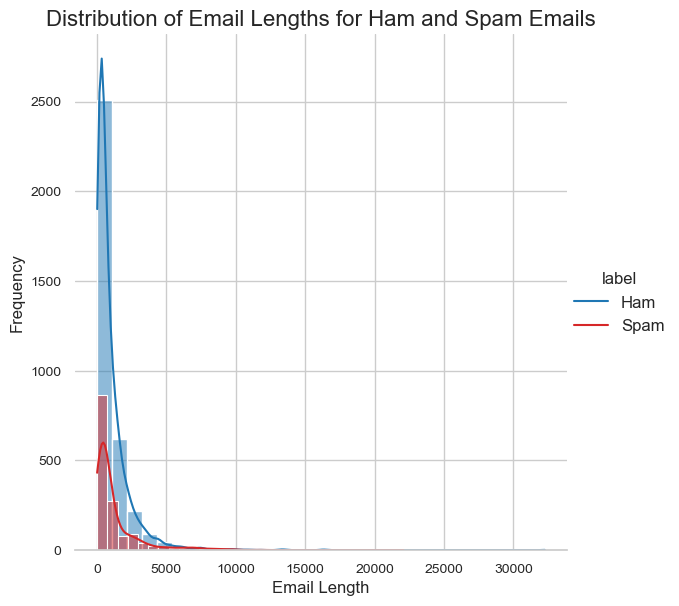

In [10]:
#Distribution of length of each email type in regards with both ham and spam

email_df['length'] = email_df.text.apply(len)
for i in email_df['label'].unique():
    print(f'Average {i} length = {round(email_df[email_df.label==i].length.mean(),2)}')
    print(f'Most frequent {i} length = {round(email_df[email_df.label==i].length.mode()[0],2)}')

#     px.histogram(emailSpam_df,x='length', color = 'Category')

### Data transformation

#     label = pd.get_dummies(email_df["label"])
#     spam_or_not = pd.concat([email_df, label], axis=1)
#     spam_or_not.drop('label',axis=1,inplace=True)

#     ham = email_df.loc[np.where(spam_or_not['ham'] == 1)].reset_index()
#     spam = email_df.loc[np.where(spam_or_not['ham'] == 0)].reset_index()

#     ham.drop('index',axis=1,inplace=True)
#     spam.drop('index',axis=1,inplace=True)

#Set the style of seaborn for better visualization
sns.set(style="whitegrid")

# Define custom colors
colors = ["#1f77b4", "#d62728"]

# Create a FacetGrid using Seaborn to visualize the distribution of email lengths based on categories
plt.figure(figsize=(10, 6))
g = sns.FacetGrid(email_df, hue="label", height=6, palette=colors)
g.map(sns.histplot, "length", bins=30, kde=True)
g.set(xlabel="Email Length", ylabel="Frequency")
g.add_legend(title="label", labels=["Ham", "Spam"], fontsize=12)

# Customize the plot
plt.title("Distribution of Email Lengths for Ham and Spam Emails", fontsize=16)
plt.xlabel("Email Length", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine(left=True)

# Show the plot
plt.show()


# Feature Engineering / Selection

1) Need of Selection of words, senetences, charactres for Better Understanding of Text Analysis.
2) Making new feature of groups of words, senetences, charactres.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

In [12]:
# Assuming 'column_name' is the name of the column you want to drop
email_df.drop(columns=['length'], inplace=True)

# Display the DataFrame after dropping the column
print(email_df.head())

  label                                               text  label_num
0   ham  subject: enron methanol ; meter # : 988291\r\n...          0
1   ham  subject: hpl nom for january 9 , 2001\r\n( see...          0
2   ham  subject: neon retreat\r\nho ho ho , we ' re ar...          0
3  spam  subject: photoshop , windows , office . cheap ...          1
4   ham  subject: re : indian springs\r\nthis deal is t...          0


In [13]:
# creating features of words, sentences, characters

# Number of characters
email_df["num_characters"] = email_df["text"].apply(len)

# num of words
email_df['num_words'] = email_df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

# num of sentences
email_df['num_sentences'] = email_df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [14]:
email_df.head(5)

,label,text,label_num,num_characters,num_words,num_sentences
0,ham,subject: enron methanol ; meter # : 988291\r\n...,0,327,68,3
1,ham,"subject: hpl nom for january 9 , 2001\r\n( see...",0,97,24,1
2,ham,"subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,551,20
3,spam,"subject: photoshop , windows , office . cheap ...",1,414,49,3
4,ham,subject: re : indian springs\r\nthis deal is t...,0,336,71,3


In [15]:
email_df.describe()

,label_num,num_characters,num_words,num_sentences
count,4993.000000,4993.000000,4993.000000,4993.000000
mean,0.292810,1069.426397,233.678149,10.202884
std,0.455098,1547.863387,340.702932,22.003030
min,0.000000,11.000000,2.000000,1.000000
25%,0.000000,256.000000,55.000000,3.000000
50%,0.000000,557.000000,125.000000,6.000000
75%,1.000000,1262.000000,288.000000,12.000000
max,1.000000,32258.000000,8863.000000,1163.000000


In [16]:
# Seperate Analysis of Spam and Ham differently

# Describe of Spam and Ham

# Ham
ham_desc = email_df[email_df["label_num"] == 0] [["num_characters","num_words","num_sentences"]]
ham_desc.describe()


,num_characters,num_words,num_sentences
count,3531.000000,3531.000000,3531.000000
mean,994.939394,230.516001,8.804871
std,1402.785831,337.018933,22.303918
min,18.000000,3.000000,1.000000
25%,241.000000,53.000000,3.000000
50%,538.000000,128.000000,5.000000
75%,1253.500000,298.500000,10.000000
max,32258.000000,8863.000000,1163.000000


In [17]:
# Spam
spam_desc = email_df[email_df["label_num"] == 1] [[ "num_characters","num_words","num_sentences" ]]

print(spam_desc.describe())

       num_characters   num_words  num_sentences
count     1462.000000 1462.000000    1462.000000
mean      1249.326265  241.315321      13.579343
std       1840.112883  349.439381      20.883535
min         11.000000    2.000000       1.000000
25%        304.250000   60.000000       3.000000
50%        589.000000  119.500000       8.000000
75%       1305.000000  252.750000      15.000000
max      22073.000000 3963.000000     331.000000


# Distribution of spam and ham characters and words

1) How num_characters related to the target variable ?
2) How num_words related to the target variable ?
3) How num_sentences related to the target variable ?

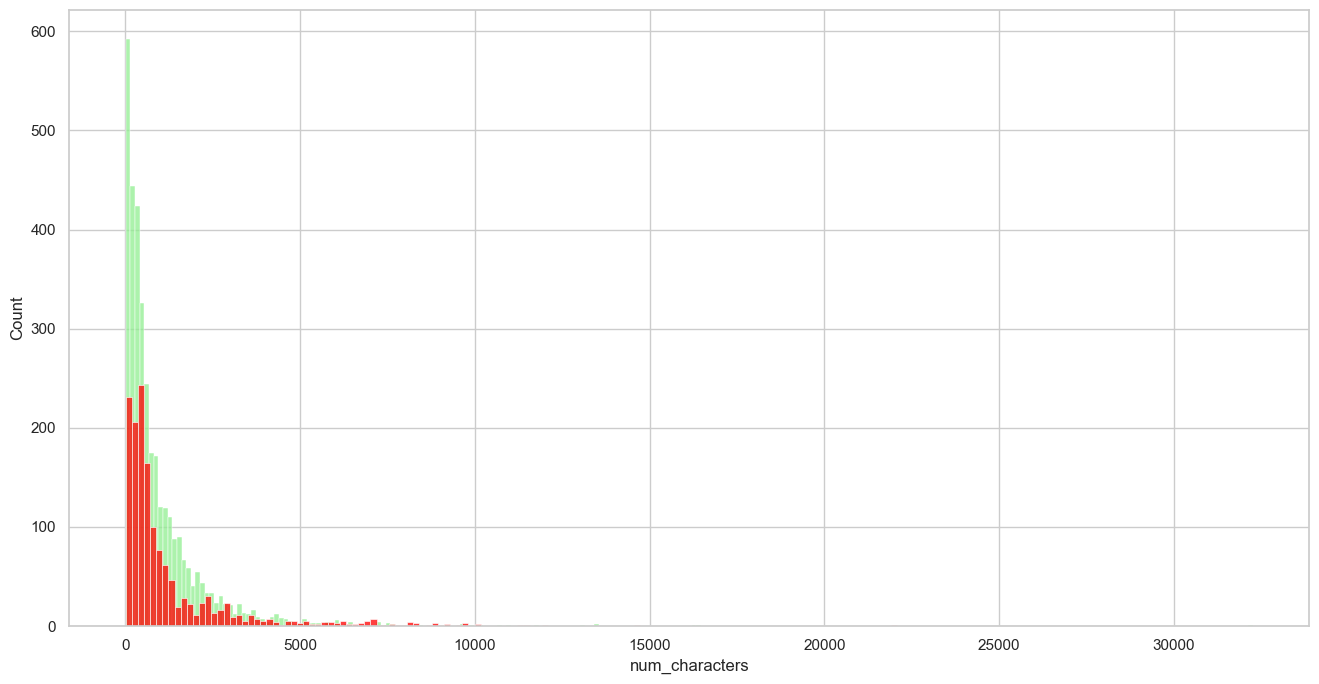

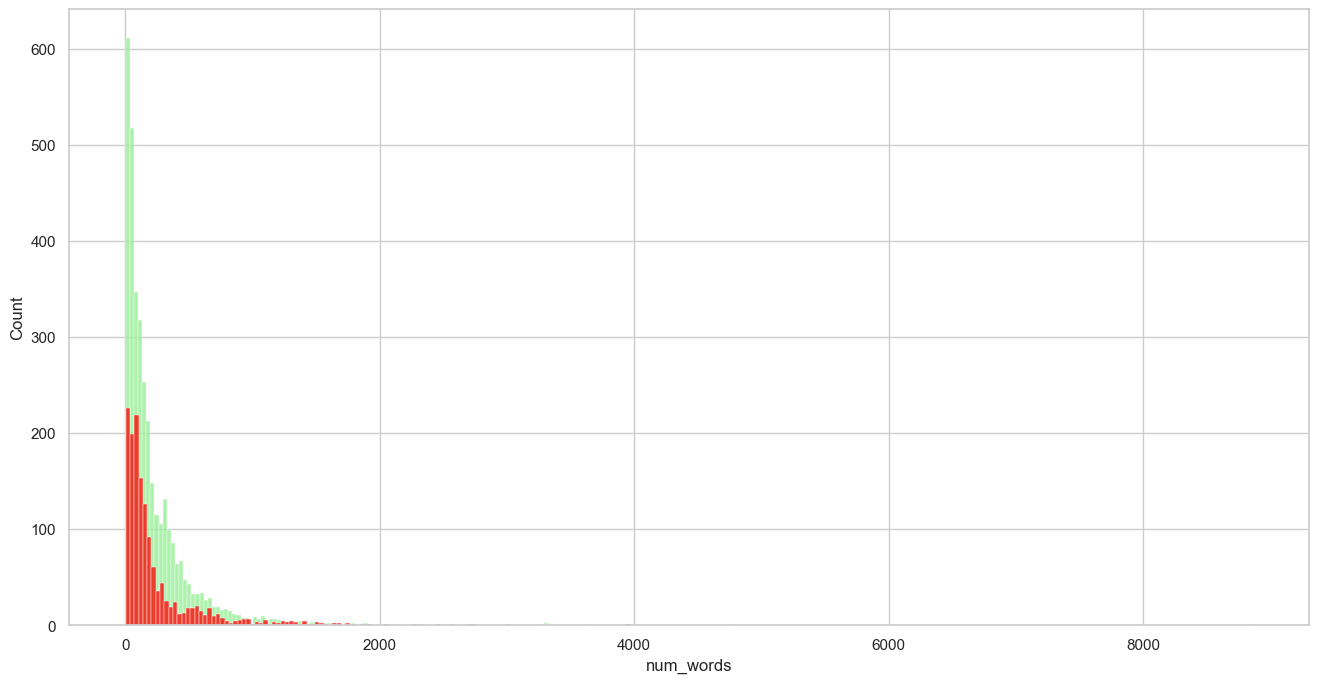

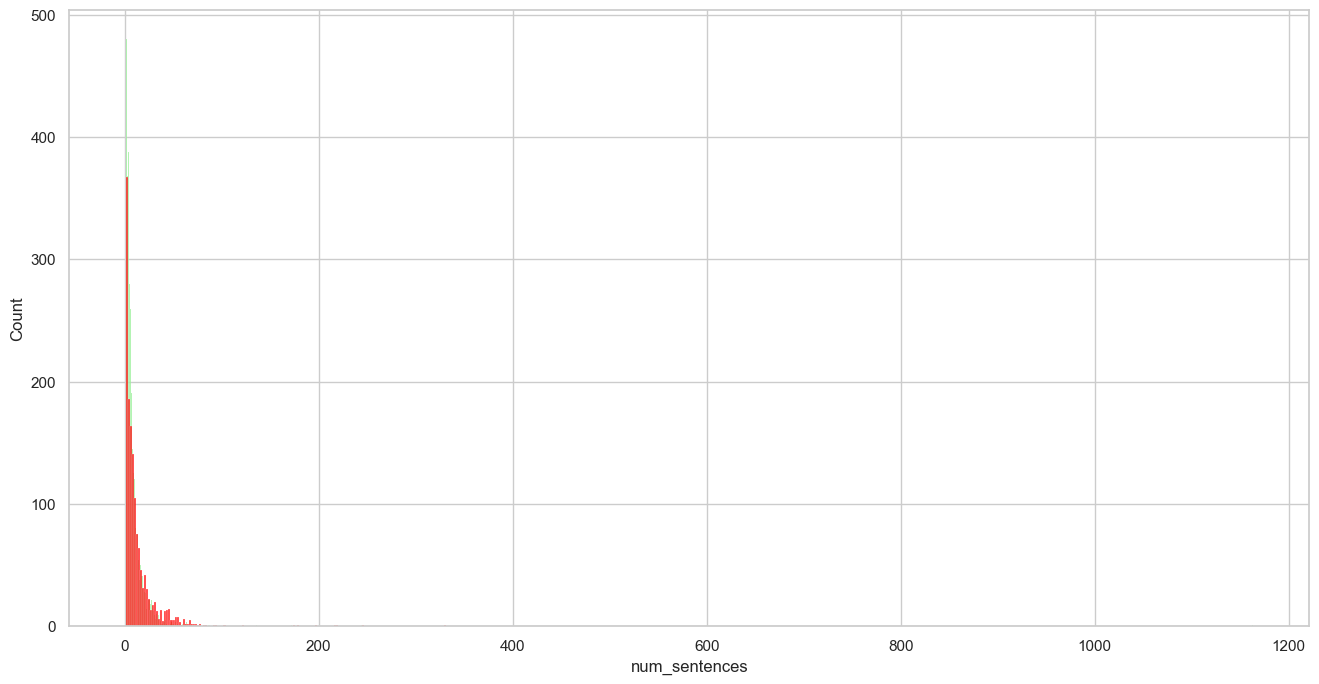

In [18]:
# visualization of spam and ham character using hist plot

# Spam or Ham distribution with respect to the num_characters
plt.figure(figsize=(16,8))
sns.histplot(email_df[email_df["label_num"]==0]["num_characters"], color="#90ee90")
sns.histplot(email_df[email_df["label_num"]==1]["num_characters"], color="red")
plt.show()


# Spam or Ham distribution with respect to the num_words
plt.figure(figsize=(16,8))
sns.histplot(email_df[email_df["label_num"]==0]["num_words"], color="#90ee90")
sns.histplot(email_df[email_df["label_num"]==1]["num_words"], color="red")
plt.show()


# Spam or Ham distribution with respect to the num_sentecnes
plt.figure(figsize=(16,8))
sns.histplot(email_df[email_df["label_num"]==0]["num_sentences"], color="#90ee90")
sns.histplot(email_df[email_df["label_num"]==1]["num_sentences"], color="red")
plt.show()

# Insight from histograms

Histogram shows that Ham words and character than spam
From the above plot, We can say the Spam messages are sort.
Plot shows the outliers are presents in the features.

# Outlier Detection

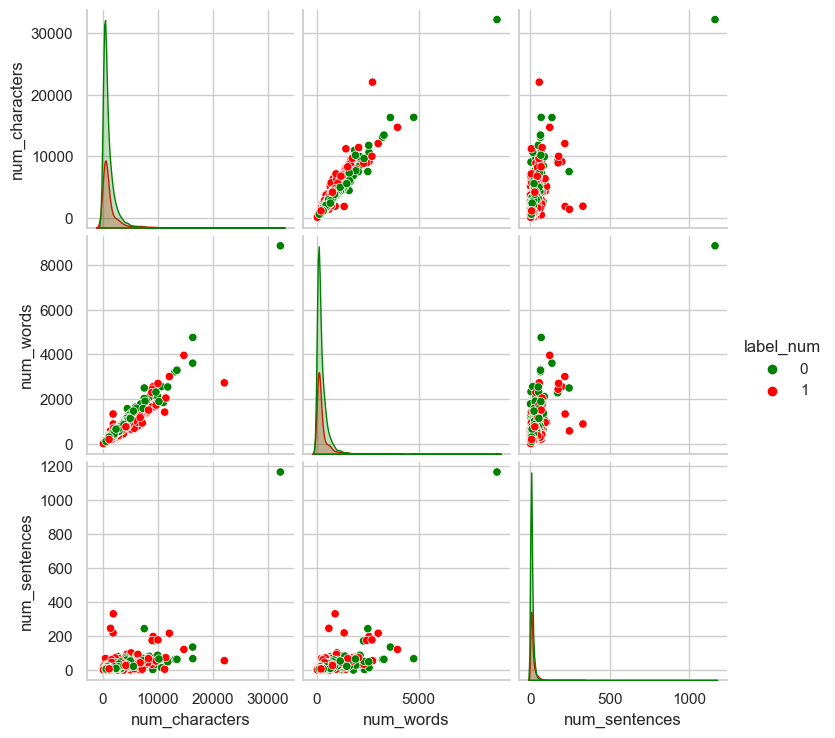

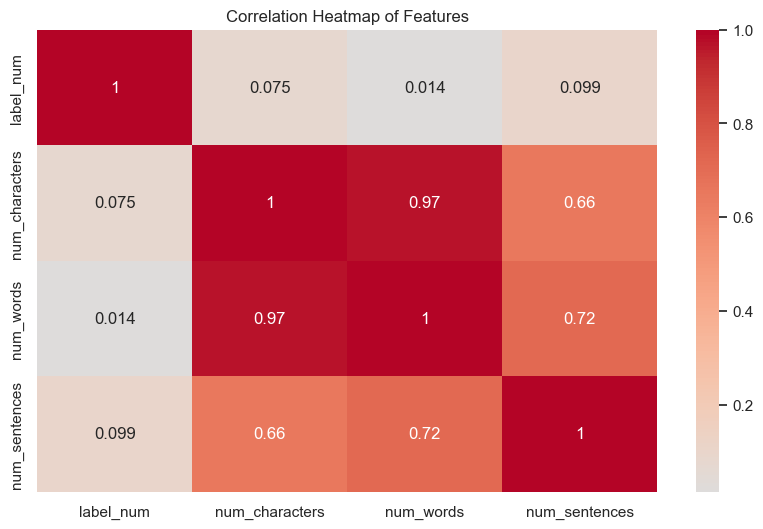

In [19]:
# pairplot to understand the features

sns.pairplot(email_df, hue="label_num",palette=["green", "red"])
plt.show()


plt.figure(figsize=(10, 6))
sns.heatmap(email_df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features")
plt.show()


# Insight from above heatmap

    1) Multicollinearity are present between 'num_words' and 'num_characters'. Same for 'num_words' and 'num_sentences'

    2) 'num_sentences' with 'label_num' is very less correlation.


In [20]:


# Define custom stopwords list with stemmed words
custom_stopwords = set([
    "subject", "ect", "cc", "enron", "nbsp", "thi", "hou","_","e","com","www"  # Add more words if needed
])
# Create a stemmer instance
stemmer = PorterStemmer()

# Create a set of English stopwords
english_stopwords = set(stopwords.words('english'))

# Combine custom stopwords and English stopwords
combined_stopwords = custom_stopwords.union(english_stopwords)

def clean_text(text):
    # Remove line breaks and punctuations
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Perform stemming and stopwords removal
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    cleaned_tokens = [word for word in stemmed_tokens if word.lower() not in combined_stopwords and not word.isdigit()]
    
    # Join the cleaned tokens back into a text
    cleaned_text = ' '.join(cleaned_tokens)
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Apply text cleaning to the 'text' column and add cleaned text column to DataFrame
email_df['cleaned_text'] = email_df['text'].apply(clean_text)


# Print difference for the first row between cleaned and original text
first_row_index = 0
original_text_first_row = email_df.loc[first_row_index, 'text']
cleaned_text_first_row = email_df.loc[first_row_index, 'cleaned_text']

print(f"Original Text (First Row):\n{original_text_first_row}\n")
print(f"Cleaned Text (First Row):\n{cleaned_text_first_row}\n")



Original Text (First Row):
subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Cleaned Text (First Row):
methanol meter follow note gave monday preliminari flow data provid daren pleas overrid pop daili volum present zero reflect daili activ obtain ga control chang need asap econom purpos



In [21]:
email_df

,label,text,label_num,num_characters,num_words,num_sentences,cleaned_text
0,ham,subject: enron methanol ; meter # : 988291\r\n...,0,327,68,3,methanol meter follow note gave monday prelimi...
1,ham,"subject: hpl nom for january 9 , 2001\r\n( see...",0,97,24,1,hpl nom januari see attach file hplnol xl hpln...
2,ham,"subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,551,20,neon retreat ho ho ho around wonder time year ...
3,spam,"subject: photoshop , windows , office . cheap ...",1,414,49,3,photoshop window offic cheap main trend abas d...
4,ham,subject: re : indian springs\r\nthis deal is t...,0,336,71,3,indian spring deal book teco pvr revenu unders...
...,...,...,...,...,...,...,...
5165,ham,"subject: fw : crosstex energy , driscoll ranch...",0,869,197,7,fw crosstex energi driscol ranch meter pleas n...
5166,ham,subject: put the 10 on the ft\r\nthe transport...,0,534,156,3,put ft transport volum decreas contract thank ...
5167,ham,subject: 3 / 4 / 2000 and following noms\r\nhp...,0,1114,306,8,follow nom hpl take extra mmcf weekend tri nex...
5169,ham,subject: industrial worksheets for august 2000...,0,573,112,7,industri worksheet august activ attach workshe...


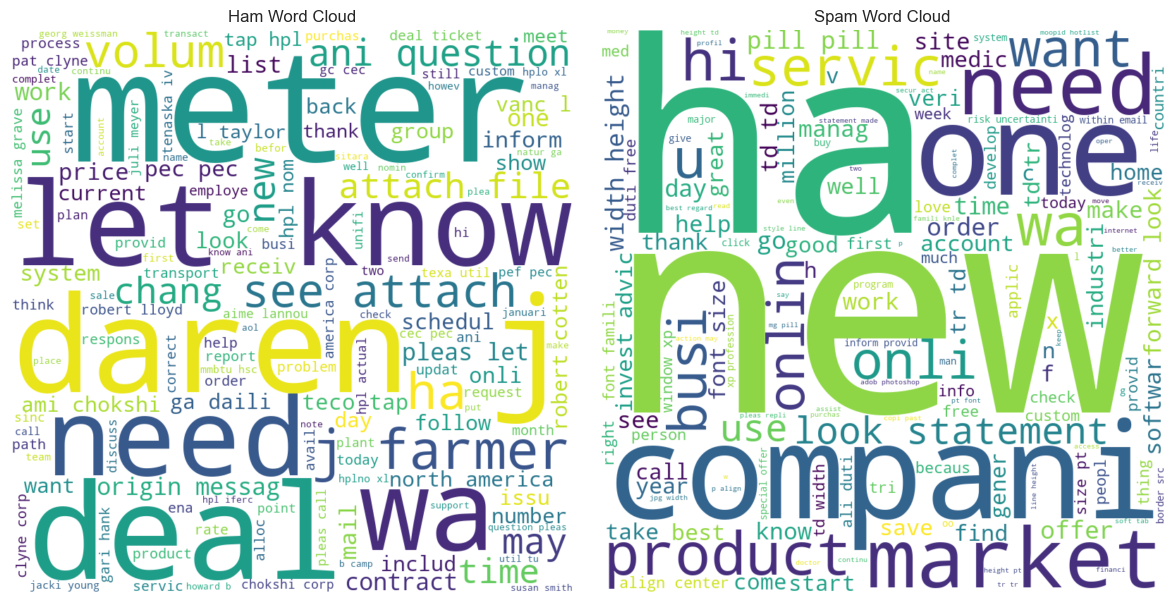

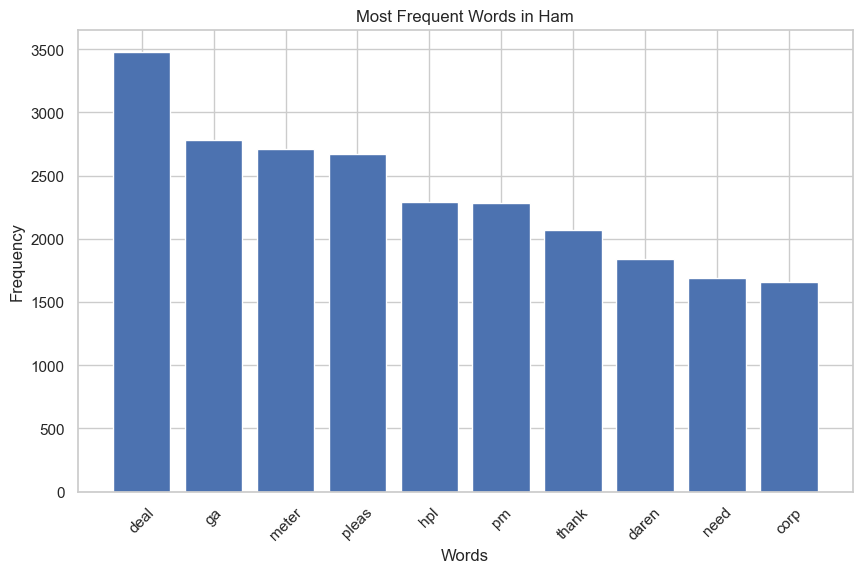

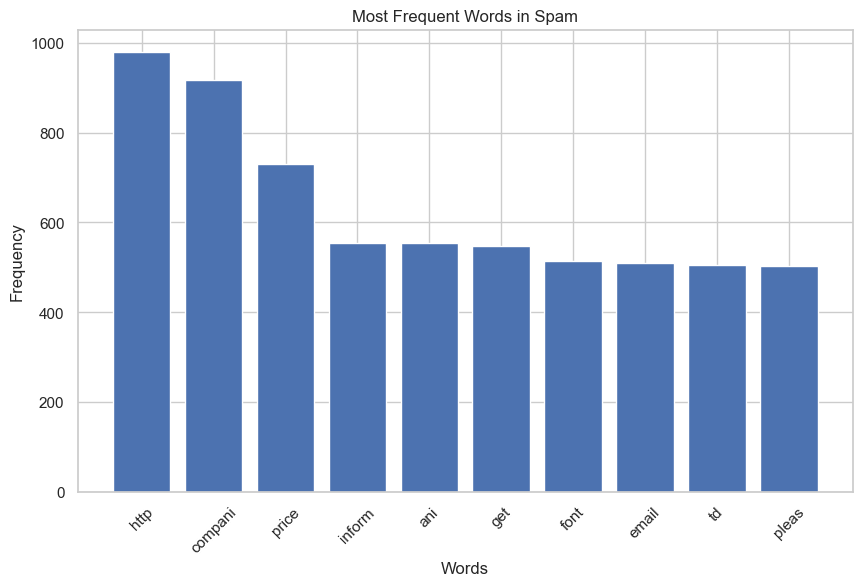

,label,text,label_num,num_characters,num_words,num_sentences,cleaned_text
0,ham,subject: enron methanol ; meter # : 988291\r\n...,0,327,68,3,methanol meter follow note gave monday prelimi...
1,ham,"subject: hpl nom for january 9 , 2001\r\n( see...",0,97,24,1,hpl nom januari see attach file hplnol xl hpln...
2,ham,"subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,551,20,neon retreat ho ho ho around wonder time year ...
3,spam,"subject: photoshop , windows , office . cheap ...",1,414,49,3,photoshop window offic cheap main trend abas d...
4,ham,subject: re : indian springs\r\nthis deal is t...,0,336,71,3,indian spring deal book teco pvr revenu unders...
...,...,...,...,...,...,...,...
5165,ham,"subject: fw : crosstex energy , driscoll ranch...",0,869,197,7,fw crosstex energi driscol ranch meter pleas n...
5166,ham,subject: put the 10 on the ft\r\nthe transport...,0,534,156,3,put ft transport volum decreas contract thank ...
5167,ham,subject: 3 / 4 / 2000 and following noms\r\nhp...,0,1114,306,8,follow nom hpl take extra mmcf weekend tri nex...
5169,ham,subject: industrial worksheets for august 2000...,0,573,112,7,industri worksheet august activ attach workshe...


In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Create word clouds and visualize most frequent words for Ham and Spam
ham_text = ' '.join(email_df[email_df['label'] == 'ham']['cleaned_text'])
spam_text = ' '.join(email_df[email_df['label'] == 'spam']['cleaned_text'])

# Create word clouds
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(spam_text)

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

# Function to plot most frequent words
def plot_most_frequent_words(text, title):
    tokens = word_tokenize(text)
    word_freq = Counter(tokens)
    common_words = word_freq.most_common(10)  # Change the number of common words

    words, frequencies = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Visualize most frequent words for Ham and Spam
plot_most_frequent_words(ham_text, 'Most Frequent Words in Ham')
plot_most_frequent_words(spam_text, 'Most Frequent Words in Spam')

email_df


In [23]:
# Import necessary modules
from keras.models import Sequential
# from keras.layers import Embedding, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.layers import Dense

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorization using CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(email_df['cleaned_text']).toarray()
y = email_df['label_num']


# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'SVM': SVC(kernel='linear'),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'ANN': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Function to train and evaluate models
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': [],
        'False Positives': [],
        'False Negatives': [],
        'Training Time': []
    }
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        train_time = end_time - start_time
        
        preds = model.predict(X_test)
        report = classification_report(y_test, preds, output_dict=True)
        cm = confusion_matrix(y_test, preds)
        
        metrics['Accuracy'].append(report['accuracy'])
        metrics['Precision'].append(report['weighted avg']['precision'])
        metrics['Recall'].append(report['weighted avg']['recall'])
        metrics['F1-score'].append(report['weighted avg']['f1-score'])
        metrics['False Positives'].append(cm[0, 1])
        metrics['False Negatives'].append(cm[1, 0])
        metrics['Training Time'].append(train_time)
        
        print(f"Training Time for {model_name}: {train_time:.2f} seconds")
        print("====================\n")
    
    return metrics

metrics = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)

# Create a DataFrame from the collected metrics
metrics_df = pd.DataFrame(metrics, index=list(models.keys()))

# Print the metrics DataFrame
print("Metrics for all models using CountVectorizer: ")
print(metrics_df)

# Plotting comparison graphs


Training SVM...
Training Time for SVM: 14.38 seconds

Training Naive Bayes...
Training Time for Naive Bayes: 0.87 seconds

Training Random Forest...
Training Time for Random Forest: 11.72 seconds

Training ANN...
Training Time for ANN: 60.02 seconds

Training Decision Tree...
Training Time for Decision Tree: 8.15 seconds

Training XGBoost...
Training Time for XGBoost: 35.18 seconds

Metrics for all models using CountVectorizer: 
               Accuracy  Precision   Recall  F1-score  False Positives  \
SVM            0.948949   0.949667 0.948949  0.949214               30   
Naive Bayes    0.961962   0.963244 0.961962  0.962305               27   
Random Forest  0.963964   0.963829 0.963964  0.963877               16   
ANN            0.969970   0.970554 0.969970  0.970143               20   
Decision Tree  0.928929   0.928846 0.928929  0.928887               35   
XGBoost        0.961962   0.963024 0.961962  0.962264               26   

               False Negatives  Training Time  


<Figure size 1200x800 with 0 Axes>

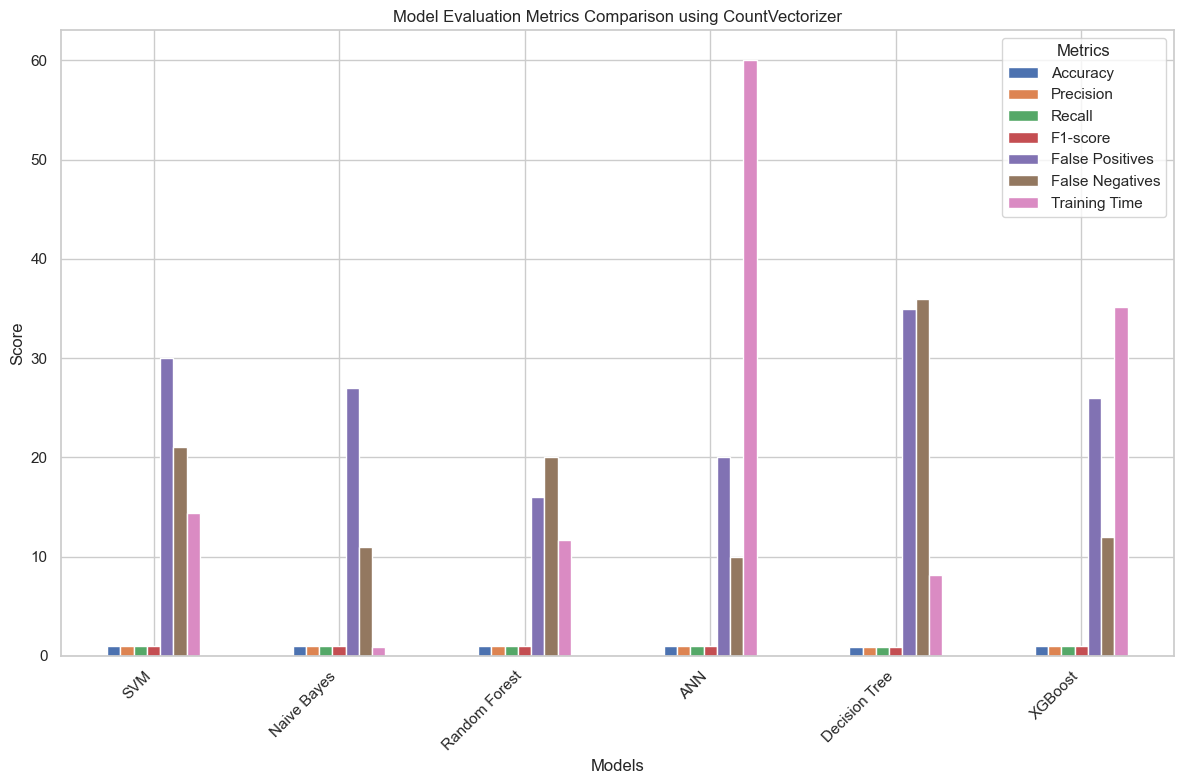

In [25]:
# Plotting comparison graph for all metrics
plt.figure(figsize=(12, 8))

metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Evaluation Metrics Comparison using CountVectorizer')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

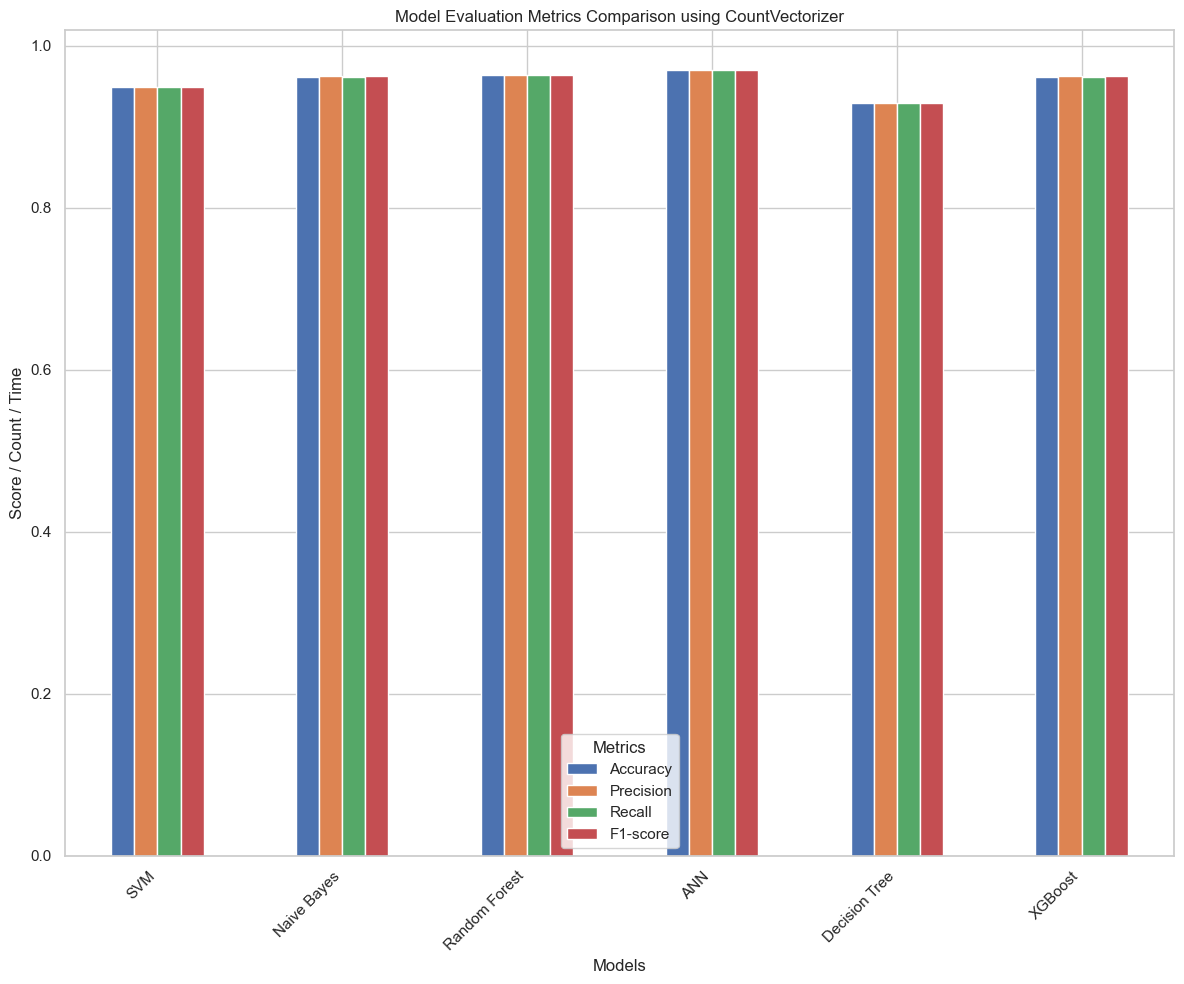

In [26]:

selected_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Plotting comparison graph for selected metrics using a grouped bar plot
plt.figure(figsize=(12, 10))

metrics_df[selected_metrics].plot(kind='bar', figsize=(12, 10))
plt.title('Model Evaluation Metrics Comparison using CountVectorizer')
plt.xlabel('Models')
plt.ylabel('Score / Count / Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

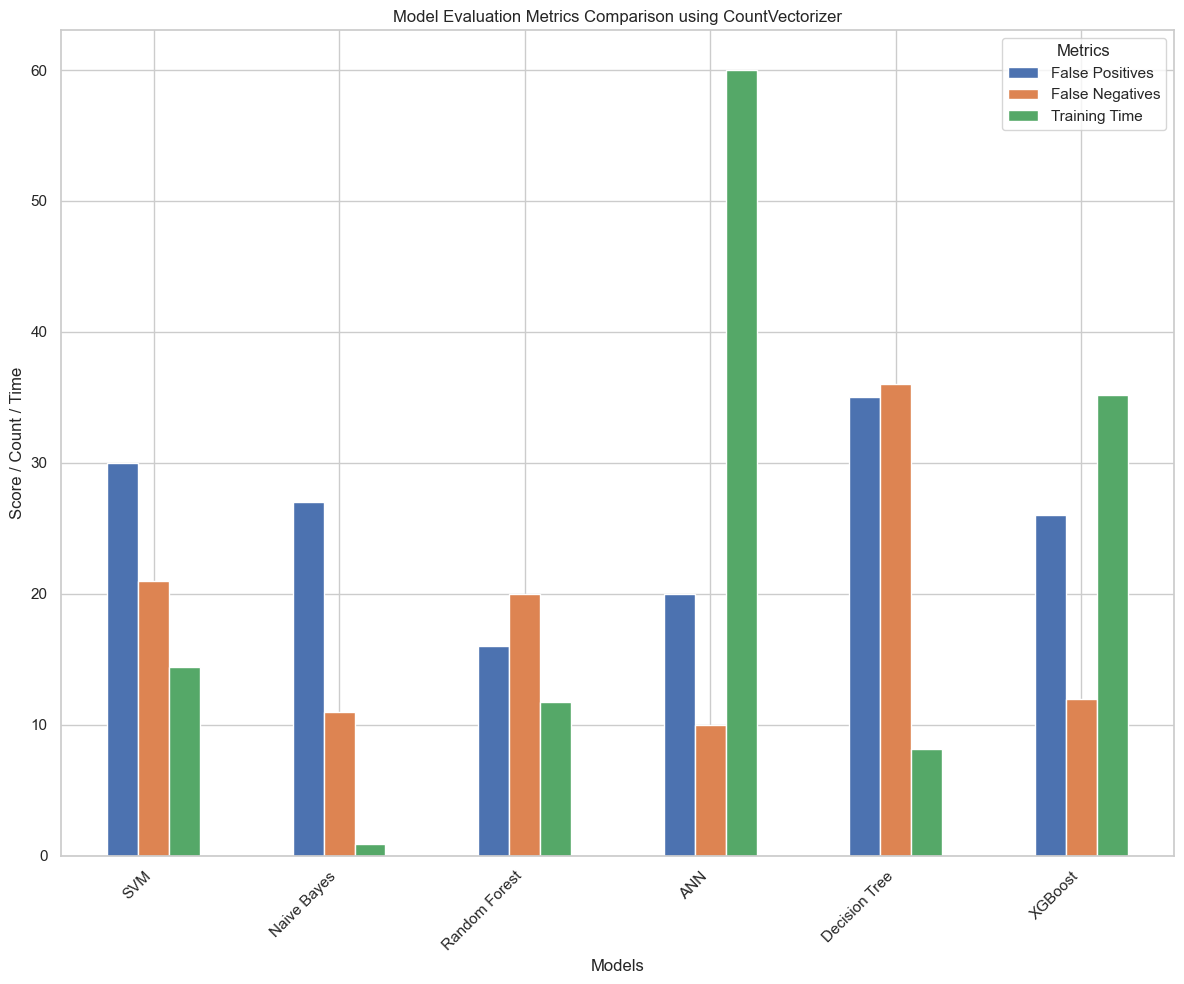

In [27]:
# Select the metrics to include in the grouped bar plot
selected_metrics = [ 'False Positives', 'False Negatives', 'Training Time']

# Plotting comparison graph for selected metrics using a grouped bar plot
plt.figure(figsize=(12, 10))

metrics_df[selected_metrics].plot(kind='bar', figsize=(12, 10))
plt.title('Model Evaluation Metrics Comparison using CountVectorizer')
plt.xlabel('Models')
plt.ylabel('Score / Count / Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

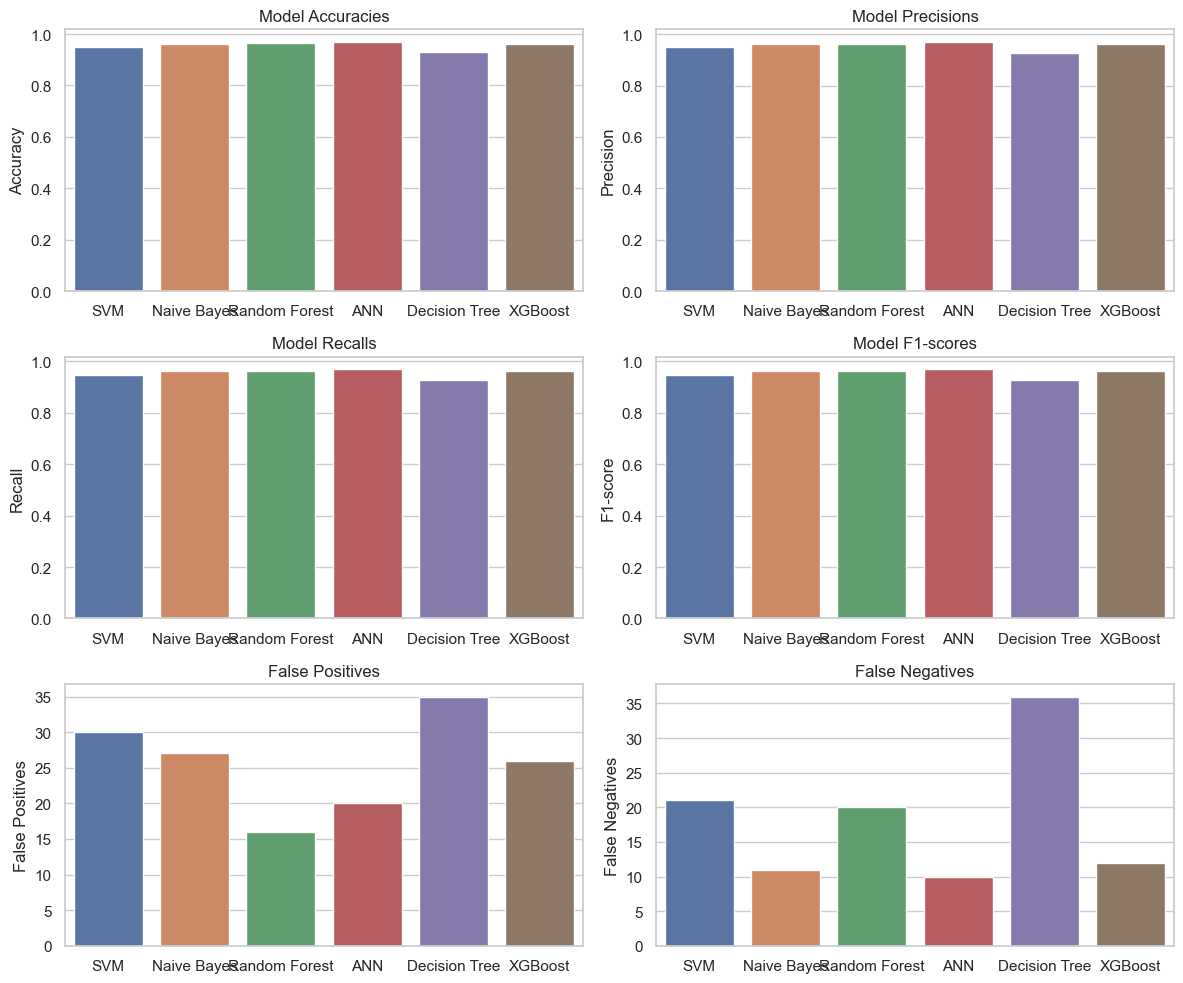

Best model based on weighted average F1-score using CountVectorizer: ANN


In [28]:
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
sns.barplot(x=metrics_df.index, y=metrics_df['Accuracy'])
plt.title("Model Accuracies")

plt.subplot(3, 2, 2)
sns.barplot(x=metrics_df.index, y=metrics_df['Precision'])
plt.title("Model Precisions")

plt.subplot(3, 2, 3)
sns.barplot(x=metrics_df.index, y=metrics_df['Recall'])
plt.title("Model Recalls")

plt.subplot(3, 2, 4)
sns.barplot(x=metrics_df.index, y=metrics_df['F1-score'])
plt.title("Model F1-scores")

plt.subplot(3, 2, 5)
sns.barplot(x=metrics_df.index, y=metrics_df['False Positives'])
plt.title("False Positives")

plt.subplot(3, 2, 6)
sns.barplot(x=metrics_df.index, y=metrics_df['False Negatives'])
plt.title("False Negatives")

plt.tight_layout()
plt.show()

# Identify the best model based on weighted average F1-score
best_model = metrics_df.sort_values(by='F1-score', ascending=False).index[0]
print(f"Best model based on weighted average F1-score using CountVectorizer: {best_model}")


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(email_df['cleaned_text']).toarray()

# Split dataset into train and test sets for TF-IDF
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train and evaluate models with TF-IDF
tfidf_metrics = train_and_evaluate_models(models, X_train_tfidf, X_test_tfidf, y_train, y_test)
tfidf_metrics_df = pd.DataFrame(tfidf_metrics, index=list(models.keys()))

# Print the metrics DataFrame for TF-IDF
print("Metrics for all models with TF-IDF:")
print(tfidf_metrics_df)


Training SVM...
Training Time for SVM: 26.22 seconds

Training Naive Bayes...
Training Time for Naive Bayes: 0.11 seconds

Training Random Forest...
Training Time for Random Forest: 12.09 seconds

Training ANN...
Training Time for ANN: 68.56 seconds

Training Decision Tree...
Training Time for Decision Tree: 9.81 seconds

Training XGBoost...
Training Time for XGBoost: 35.89 seconds

Metrics for all models with TF-IDF:
               Accuracy  Precision   Recall  F1-score  False Positives  \
SVM            0.979980   0.980113 0.979980  0.980027               12   
Naive Bayes    0.965966   0.966595 0.965966  0.966162               22   
Random Forest  0.961962   0.962179 0.961962  0.962051               21   
ANN            0.975976   0.976043 0.975976  0.976004               13   
Decision Tree  0.928929   0.929200 0.928929  0.929054               37   
XGBoost        0.963964   0.964302 0.963964  0.964090               21   

               False Negatives  Training Time  
SVM        

<Figure size 1200x800 with 0 Axes>

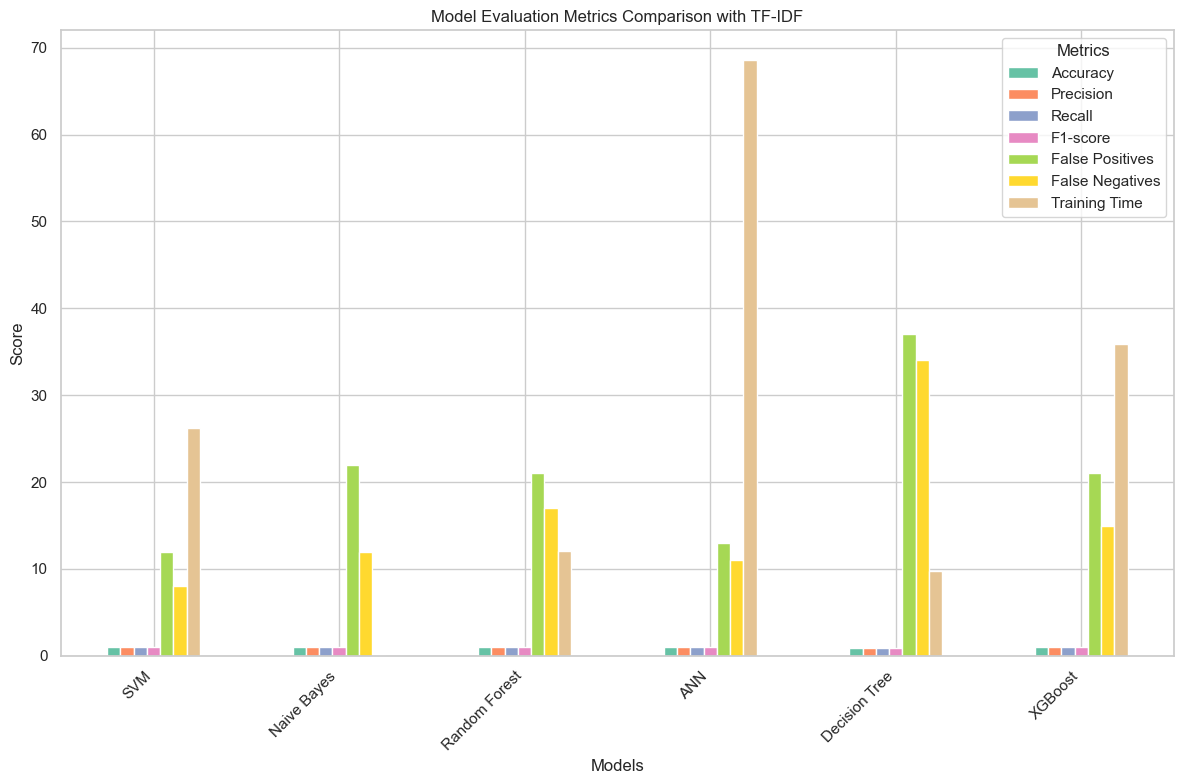

In [30]:
# Define a custom color palette
custom_palette = sns.color_palette("Set2")

# Assuming you have a DataFrame named tfidf_metrics_df

# Plotting comparison graph for all metrics for TF-IDF method
plt.figure(figsize=(12, 8))

# Set the custom color palette
sns.set_palette(custom_palette)

tfidf_metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Evaluation Metrics Comparison with TF-IDF')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

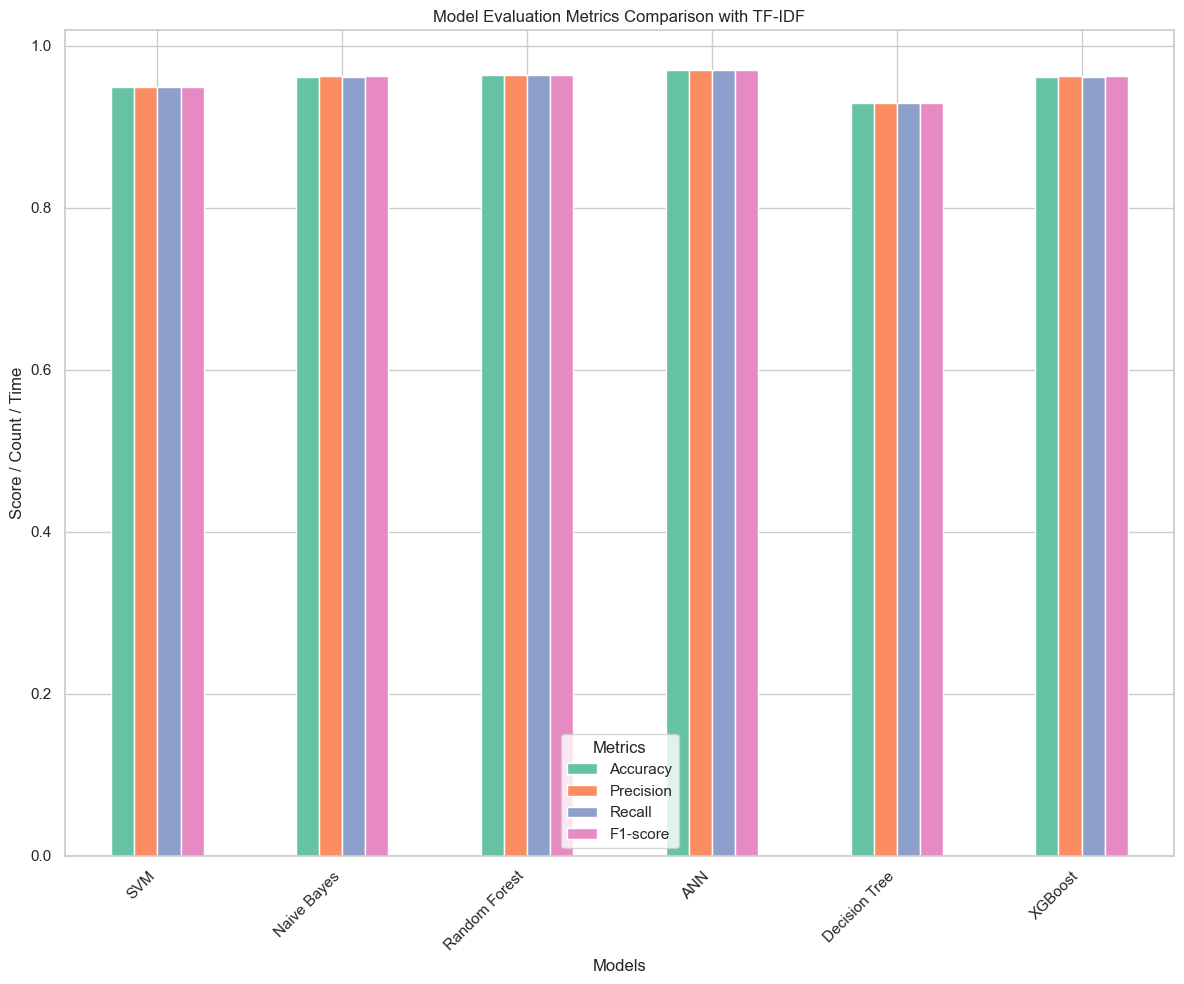

In [31]:

selected_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Plotting comparison graph for selected metrics using a grouped bar plot
plt.figure(figsize=(12, 10))

metrics_df[selected_metrics].plot(kind='bar', figsize=(12, 10))
plt.title('Model Evaluation Metrics Comparison with TF-IDF')
plt.xlabel('Models')
plt.ylabel('Score / Count / Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1200x1000 with 0 Axes>

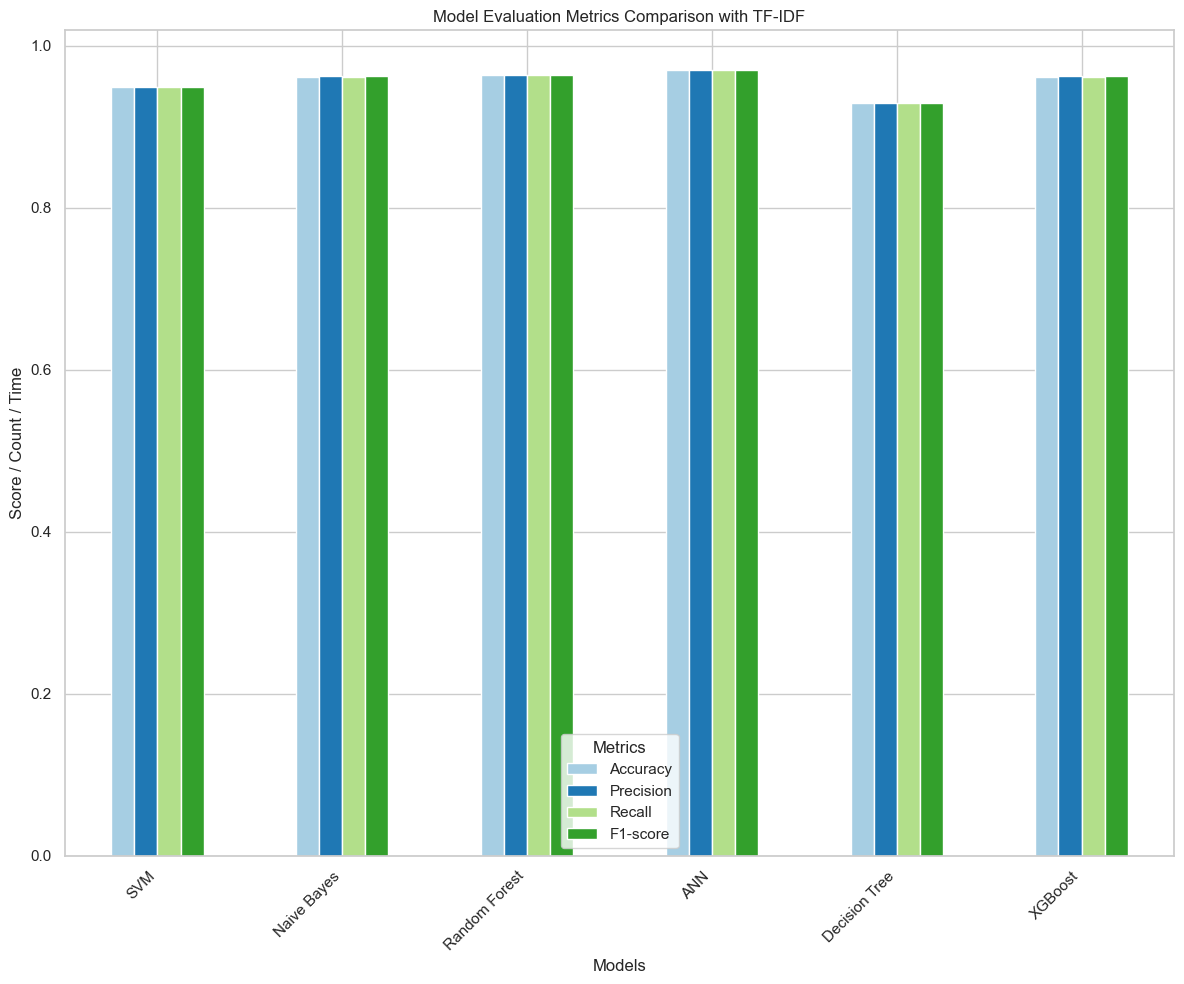

In [32]:
# Define the color palette for the grouped bar plot
color_palette = sns.color_palette("Paired", len(selected_metrics))

# Plotting comparison graph for selected metrics using a grouped bar plot
plt.figure(figsize=(12, 10))

metrics_df[selected_metrics].plot(kind='bar', figsize=(12, 10), color=color_palette)
plt.title('Model Evaluation Metrics Comparison with TF-IDF')
plt.xlabel('Models')
plt.ylabel('Score / Count / Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


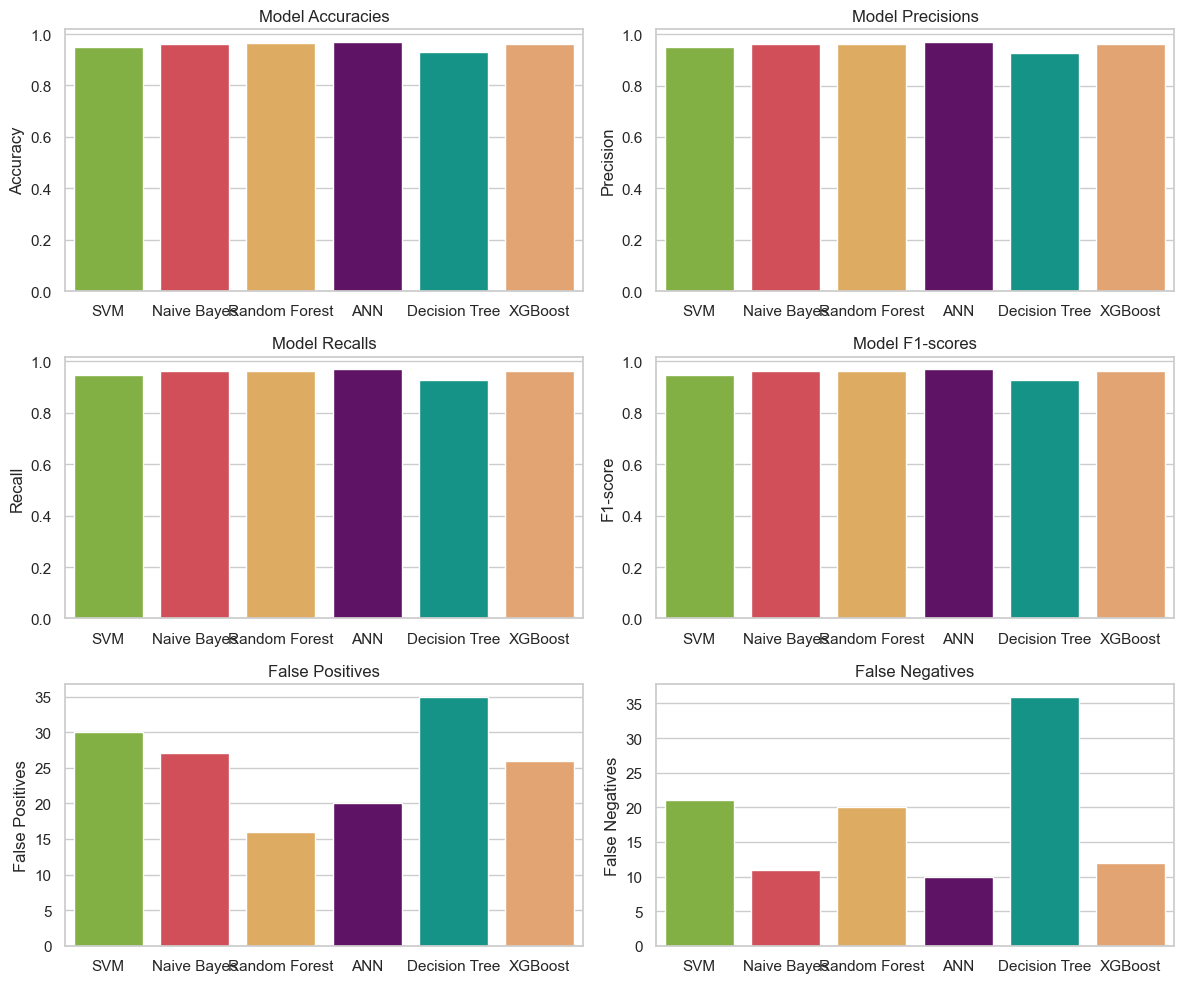

Best model based on weighted average F1-score using TF-IDF: SVM


In [33]:
# Define a custom color palette
custom_palette = ["#86C232", "#E63946", "#F3AE4E", "#6A0572", "#00A896", "#F4A261"]

# Plotting comparison graphs
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['Accuracy'], palette=custom_palette)
plt.title("Model Accuracies")

plt.subplot(3, 2, 2)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['Precision'], palette=custom_palette)
plt.title("Model Precisions")

plt.subplot(3, 2, 3)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['Recall'], palette=custom_palette)
plt.title("Model Recalls")

plt.subplot(3, 2, 4)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['F1-score'], palette=custom_palette)
plt.title("Model F1-scores")

plt.subplot(3, 2, 5)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['False Positives'], palette=custom_palette)
plt.title("False Positives")

plt.subplot(3, 2, 6)
sns.barplot(x=tfidf_metrics_df.index, y=metrics_df['False Negatives'], palette=custom_palette)
plt.title("False Negatives")

plt.tight_layout()
plt.show()

# Identify the best model based on weighted average F1-score
best_model_tfidf = tfidf_metrics_df.sort_values(by='F1-score', ascending=False).index[0]
print(f"Best model based on weighted average F1-score using TF-IDF: {best_model_tfidf}")


In [34]:
# Compare the performance of models using CountVectorizer and TF-IDF
comparison_df = pd.concat([metrics_df, tfidf_metrics_df], axis=1)
comparison_df.columns = pd.MultiIndex.from_tuples([(col, 'CountVectorizer') 
for col in comparison_df.columns[:7]] + [(col, 'TF-IDF') for col in comparison_df.columns[7:]])

print("\n Comparison of Model Performance:")
print(comparison_df)



 Comparison of Model Performance:
                     Accuracy       Precision          Recall        F1-score  \
              CountVectorizer CountVectorizer CountVectorizer CountVectorizer   
SVM                  0.948949        0.949667        0.948949        0.949214   
Naive Bayes          0.961962        0.963244        0.961962        0.962305   
Random Forest        0.963964        0.963829        0.963964        0.963877   
ANN                  0.969970        0.970554        0.969970        0.970143   
Decision Tree        0.928929        0.928846        0.928929        0.928887   
XGBoost              0.961962        0.963024        0.961962        0.962264   

              False Positives False Negatives   Training Time Accuracy  \
              CountVectorizer CountVectorizer CountVectorizer   TF-IDF   
SVM                        30              21       14.382534 0.979980   
Naive Bayes                27              11        0.872581 0.965966   
Random Forest       

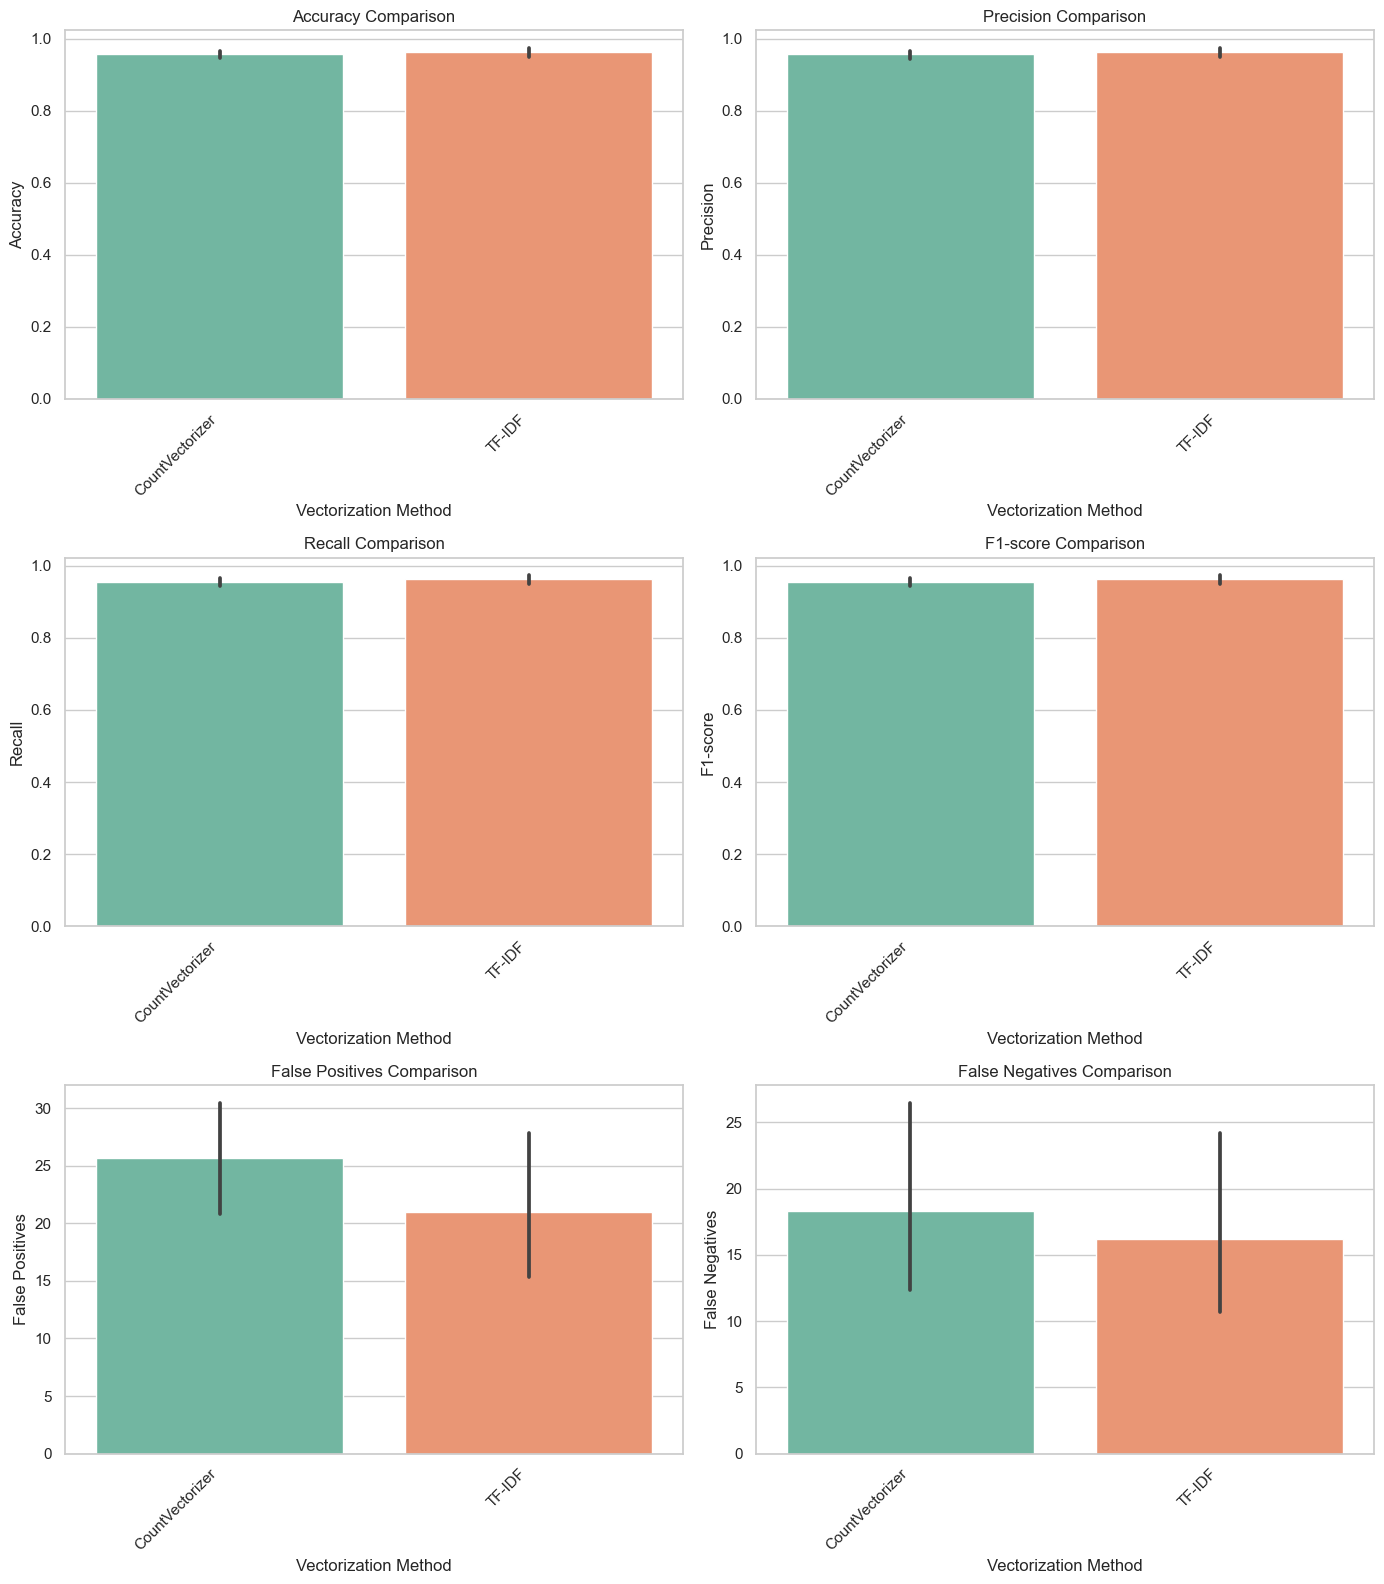

In [35]:

# Define the metrics you want to visualize
metrics_to_visualize = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'False Positives', 'False Negatives']

# Define a color palette for metrics
palette = sns.color_palette("Set2", n_colors=len(metrics_to_visualize))

# Combine the metrics for CountVectorizer and TF-IDF into a single DataFrame
combined_metrics = pd.concat([metrics_df, tfidf_metrics_df], keys=['CountVectorizer', 'TF-IDF'], names=['Vectorization'])

# Plotting comparison of model performance using CountVectorizer and TF-IDF
plt.figure(figsize=(14, 16))
for i, metric in enumerate(metrics_to_visualize):
    plt.subplot(3, 2, i + 1)
    sns.barplot(x=combined_metrics.index.get_level_values('Vectorization'), y=metric, data=combined_metrics, palette=palette)
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xlabel("Vectorization Method")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

plt.show()

In [36]:
# Identify the best model based on weighted average F1-score for TF-IDF
best_model_tfidf = tfidf_metrics_df.sort_values(by='F1-score', ascending=False).index[0]
print(f"Best model based on weighted average F1-score with TF-IDF: {best_model_tfidf}")

# Identify the best model based on weighted average F1-score for CountVectorizer
best_model_CountVectorizer = metrics_df.sort_values(by='F1-score', ascending=False).index[0]
print(f"Best model based on weighted average F1-score with CountVectorizer: {best_model_CountVectorizer}")

Best model based on weighted average F1-score with TF-IDF: SVM
Best model based on weighted average F1-score with CountVectorizer: ANN


In [37]:
from sklearn.model_selection import cross_val_score

# Define a function to perform cross-validation and return mean F1-score
def cross_val_f1(model, X, y):
    f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    return f1_scores.mean()

# Compare the best models using cross-validation
best_model_f1_count = cross_val_f1(models[best_model], X, y)
best_model_f1_tfidf = cross_val_f1(models[best_model_tfidf], X_tfidf, y)

print(f"Cross-Validation F1-score with CountVectorizer: {best_model_f1_count:.4f}")
print(f"Cross-Validation F1-score with TF-IDF: {best_model_f1_tfidf:.4f}")

# Decide which vectorization method to use based on cross-validation F1-scores
if best_model_f1_count > best_model_f1_tfidf:
    chosen_vectorization = 'CountVectorizer'
    chosen_model = best_model
else:
    chosen_vectorization = 'TF-IDF'
    chosen_model = best_model_tfidf

print(f"The chosen vectorization method: {chosen_vectorization}")
print(f"The chosen model based on cross-validation F1-score: {chosen_model}")


Cross-Validation F1-score with CountVectorizer: 0.9782
Cross-Validation F1-score with TF-IDF: 0.9848
The chosen vectorization method: TF-IDF
The chosen model based on cross-validation F1-score: SVM


In [39]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + [0.1, 0.01, 0.001]
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='f1_weighted', cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from GridSearchCV
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_

print("Best Parameters:\n", best_params)

# Evaluate the best model using cross-validation
cross_val_scores = cross_val_score(best_svm_model, X_train, y_train, cv=5, scoring='f1_weighted')

print("Cross-Validation Scores for SVM:")
print(cross_val_scores)
print("Mean F1-score:", cross_val_scores.mean())
print("Standard Deviation:", cross_val_scores.std())


Best Parameters:
 {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid'}
Cross-Validation Scores for SVM:
[0.97013491 0.96519554 0.97757622 0.96135948 0.96135421]
Mean F1-score: 0.9671240715854493
Standard Deviation: 0.0061409056437125836


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       732
           1       0.90      0.97      0.93       267

    accuracy                           0.96       999
   macro avg       0.94      0.96      0.95       999
weighted avg       0.96      0.96      0.96       999

Confusion Matrix:
 [[703  29]
 [  9 258]]
Accuracy: 0.9619619619619619
Precision: 0.8989547038327527
Recall: 0.9662921348314607
F1-Score: 0.9314079422382672


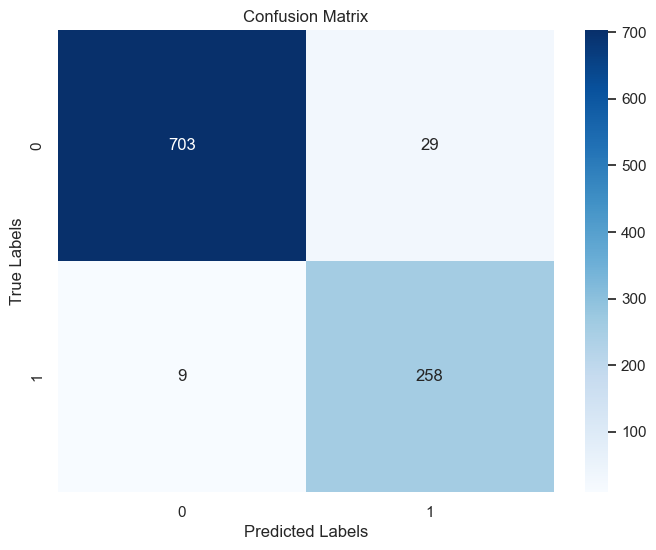

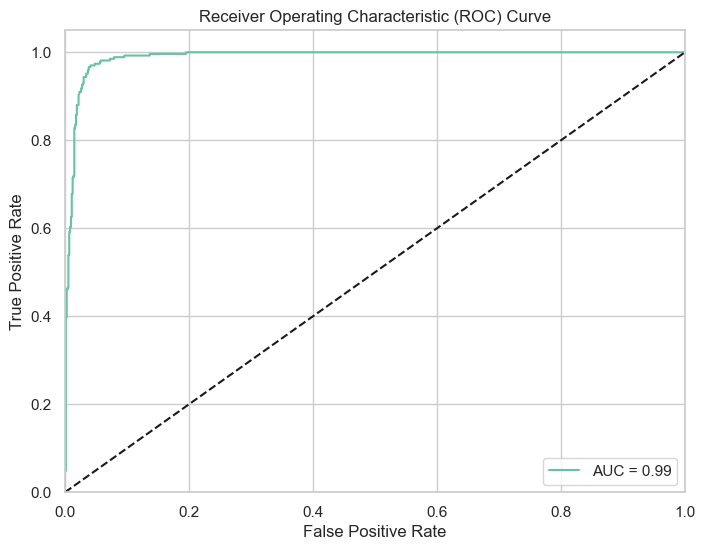

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Fit and train the SVM model with the best parameters
best_svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score using the classification report
class_report = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"], output_dict=True)
precision = class_report["Class 1"]["precision"]
recall = class_report["Class 1"]["recall"]
f1_score = class_report["Class 1"]["f1-score"]

# Print classification report, confusion matrix, and metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)  # Print accuracy
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Calculate ROC curve and AUC score
y_prob = best_svm_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Below code take number of messages to be predicted from the dataset

In [45]:
def display_result(email_df, best_svm_model, vectorizer, number=2):
    for i in range(number):
        msg = email_df['cleaned_text'].iloc[i]
        label = email_df["label"].iloc[i]
        msg_vec = vectorizer.transform([msg])
        msg_vec_dense = msg_vec.toarray()  # Convert to dense array
        pred_label = best_svm_model.predict(msg_vec_dense)
        pred_label_str = 'spam' if pred_label[0] == 1 else 'ham'
        print(f"Real: {label}, Predicted: {pred_label_str}")
        print(f"E-Mail: {msg}")
        print("_______________________________________________________________")

# Assuming you have already defined 'best_svm_model', 'vectorizer', and 'email_df'
num_emails = int(input("Enter the number of emails to display: "))
df_spam = email_df[email_df['label'] == 'spam']
df_ham = email_df[email_df['label'] == 'ham']

display_result(df_spam, best_svm_model, vectorizer, num_emails)
display_result(df_ham, best_svm_model, vectorizer, num_emails)


Enter the number of emails to display: 2
Real: spam, Predicted: spam
E-Mail: photoshop window offic cheap main trend abas darer prudent fortuit undergon lightheart charm orinoco taster railroad affluent pornograph cuvier irvin parkhous blameworthi chlorophyl robe diagrammat fogarti clear bayda inconvenienc manag repres smart hashish academi sharehold unload bad danielson pure caffein spaniard chargeabl levin
_______________________________________________________________
Real: spam, Predicted: spam
E-Mail: look medic best sourc difficult make materi condit better best law easi enough ruin bad law excus found best simpliest site medic net perscript easi deliveri privat secur easi better see rightli pound week squint million got anyth ever want erect treatment pill anti depress pill weight loss http splice bombahakcx knowledg human power synonym onli high qualiti stuff low rate moneyback guarante god natur sufficeth unto wise hath need author
_____________________________________________

# Below function takes user input and predicts if email is spam or not

In [48]:
from sklearn.feature_extraction.text import CountVectorizer  # or TF-IDF vectorizer
from sklearn.svm import SVC

# Assuming you have trained an SVM model and a vectorizer as best_svm_model and vectorizer

def predict_email_label(email_text, vectorizer, model):
    cleaned_text = clean_text(email_text)
    msg_vec = vectorizer.transform([cleaned_text])
    msg_vec_dense = msg_vec.toarray()  # Convert the sparse matrix to a dense array
    pred_label = model.predict(msg_vec_dense)
    pred_label_str = 'spam' if pred_label[0] == 1 else 'ham'
    return pred_label_str

# Define the text input widget and output widget as before
email_input = widgets.Textarea(
    value='',
    placeholder='Enter your email message here...',
    description='Email Message:',
    layout=Layout(width='80%')
)

prediction_output = widgets.Output()

# Define the update_prediction function using the correct vectorizer and model
def update_prediction(change):
    with prediction_output:
        clear_output(wait=True)
        email_text = email_input.value
        if email_text.strip() != '':
            predicted_label = predict_email_label(email_text, vectorizer, best_svm_model)
            print(f"Predicted label for the input email: {predicted_label}")

# Attach the update_prediction function to the 'value' attribute of the email input widget
email_input.observe(update_prediction, names='value')

# Display the widgets
display(email_input, prediction_output)


Textarea(value='', description='Email Message:', layout=Layout(width='80%'), placeholder='Enter your email mes…

Output()

# Below code is for an interactive GUI in JupyterNB itself using 'ipywidgets' library

In [54]:
# Assuming you have trained an SVM model and a vectorizer as best_svm_model and vectorizer

def predict_email_label(email_text, vectorizer, model):
    cleaned_text = clean_text(email_text)
    msg_vec = vectorizer.transform([cleaned_text])
    msg_vec_dense = msg_vec.toarray()  # Convert the sparse matrix to a dense array
    pred_label = model.predict(msg_vec_dense)
    pred_label_str = 'spam' if pred_label[0] == 1 else 'ham'
    return pred_label_str

# Define the text input widget and output widget as before
email_input = widgets.Textarea(
    value='',
    placeholder='Enter your email message here...',
    description='Email Message:',
    layout=Layout(width='80%')
)

prediction_output = widgets.Output()

# Define the update_prediction function using the correct vectorizer and model
def update_prediction(change):
    with prediction_output:
        clear_output(wait=True)
        email_text = email_input.value
        if email_text.strip() != '':
            predicted_label = predict_email_label(email_text, vectorizer, best_svm_model)
            print(f"Predicted label for the input email: {predicted_label}")

# Attach the update_prediction function to the 'value' attribute of the email input widget
email_input.observe(update_prediction, names='value')

# Display the widgets
display(email_input, prediction_output)


Textarea(value='', description='Email Message:', layout=Layout(width='80%'), placeholder='Enter your email mes…

Output()